In [2]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from vis_common import load_store, load_games

from crawl_data import CANON_SPECIES, CANON_BGS

f = load_games()
print "Loaded data frame with {} records and {} columns".format(
    len(f), len(f.columns))

ilost = ~f['won']
iwon = f['won']
iquit = f['howdied'] == 'quit'

FS = (10, 6) # Reasonable default figsize

species = f['species'].cat.categories
drac_species = [sp for sp in species if 'draconian' in sp]
idrac = f['species'].isin(drac_species)

Loaded data frame with 1327938 records and 24 columns


In [6]:
f.columns

Index([u'bg', u'bot', u'first_conversion', u'god', u'gold_collected',
       u'gold_spent', u'howdied', u'hunger', u'level', u'nrunes', u'pid',
       u'religious_experiences', u'score', u'species', u'temple_depth',
       u'temple_xl', u'time', u'turns', u'version', u'whereconverted',
       u'wheredied', u'won', u'orig_species', u'legit'],
      dtype='object')

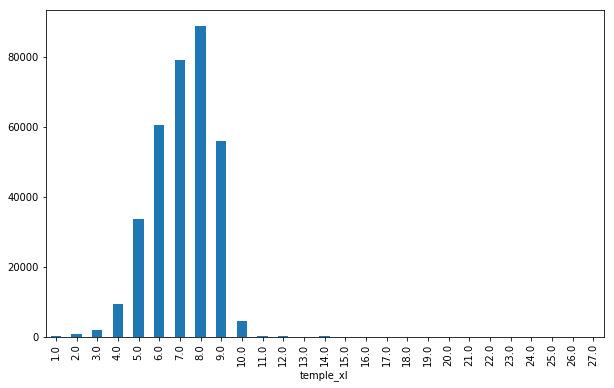

In [7]:
# Temple scumming!
f.groupby('temple_xl').size().plot.bar(figsize=FS);

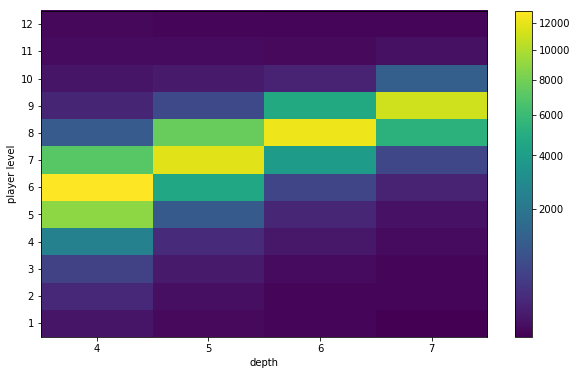

In [69]:
from matplotlib import colors
fig, ax = plt.subplots(figsize=FS)
df = f[~f['temple_depth'].isnull()].head(100000)
x = df['temple_depth'].values
y = df['temple_xl'].values
max_plvl =  12
bins = [[3.5, 4.5,5.5,6.5, 7.5], np.arange(.5,max_plvl+1.5, 1)]
norm = colors.PowerNorm(.5)
plt.hist2d(x, y, bins, 
          norm=norm,
           #normed=True,
           #ax=ax,
         );
ax.set_xlabel('depth')
ax.set_ylabel('player level')
plt.colorbar(norm=norm);
ax.set_xticks([4, 5, 6, 7]);
ax.set_yticks(range(1,max_plvl+1));
# TODO: take an equal number per depth

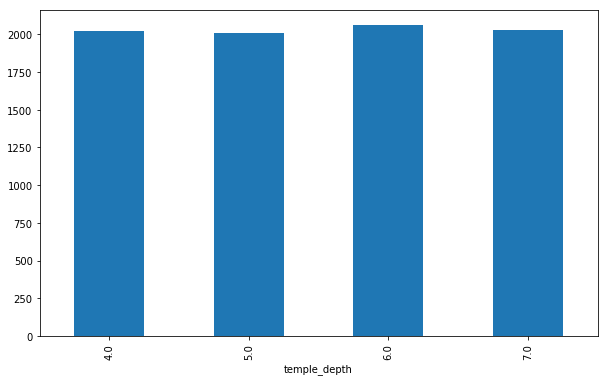

In [79]:
zealots = ['berserker', 'chaos knight', 'abyssal knight']
izealot = f['bg'].isin(zealots)
f[~izealot].groupby('temple_depth')['won'].sum().plot.bar(figsize=FS);
# I am actually amazed by this

In [80]:
f[~izealot].groupby('temple_depth')['won'].sum()

temple_depth
4.0    2019.0
5.0    2007.0
6.0    2059.0
7.0    2031.0
Name: won, dtype: float64

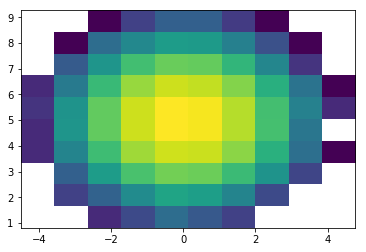

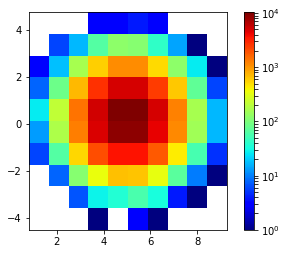

In [53]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from numpy.random import randn

#normal distribution center at x=0 and y=5
x = randn(100000)
y = randn(100000)+5

H, xedges, yedges, img = plt.hist2d(x, y, norm=LogNorm())
extent = [yedges[0], yedges[-1], xedges[0], xedges[-1]]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(H, cmap=plt.cm.jet, extent=extent, norm=LogNorm())
fig.colorbar(im, ax=ax)
plt.show()

In [17]:
f['howdied'].cat.categories

Index([u'asphyxiated', u'cloud', u'drowned', u'miscast', u'monster', u'quit',
       u'rot', u'starved', u'statdeath', u'suicide'],
      dtype='object')

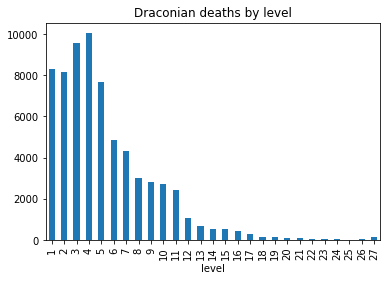

In [2]:
death_lvls = f.loc[ilost & idrac].groupby('level').size()
death_lvls.plot.bar(title='Draconian deaths by level');
# No peak at lvl 7. Guess players really aren't scumming drac colours.
# But actually looking specifically at the quitting numbers below contradicts that. Why isn't
# this phenom visible in this graph? Hypothesis: the quitters do tend to increase the death rate
# at level 7, but those who stick with their drac get a new power at level 7 that increases their
# survivability, which acts as a countervaling force
# TODO: Some day I'll understand matplotlib primitives well enough to do stuff like putting plots
# next to each other.

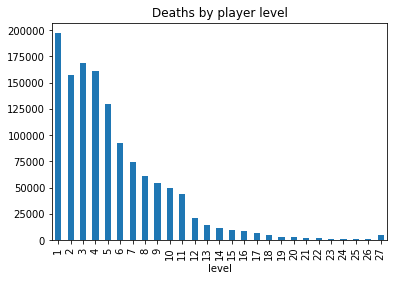

In [3]:
f.loc[ilost].groupby('level').size().plot.bar(title='Deaths by player level');

In [4]:
# Load the 'raw' data frame (which doesn't exclude games that were quit at level 1)
fr = load_frame(raw=True)
idrac_raw = fr['species'].isin(drac_species)

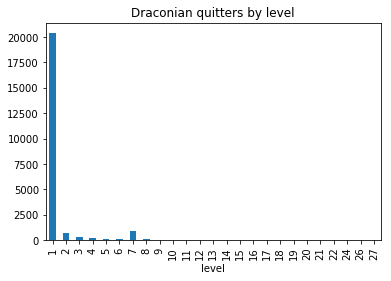

In [5]:
fr.loc[iquit & idrac_raw].groupby('level').size()\
    .plot.bar(title='Draconian quitters by level');

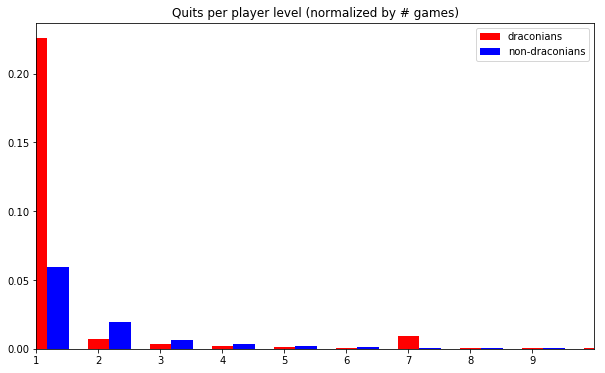

In [6]:
drac_quits_per_lvl = (fr.loc[iquit & idrac_raw].groupby('level').size() /
    idrac_raw.sum())
nondrac_quits_per_lvl = (fr.loc[iquit & ~idrac_raw].groupby('level').size() /
    (~idrac_raw).sum())
# TODO: write a function for this pattern
w = .35
PLVLS = np.arange(1,28)
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(drac_quits_per_lvl.index, drac_quits_per_lvl.values, w, label='draconians', color='r')
ax.bar(nondrac_quits_per_lvl.index+w, nondrac_quits_per_lvl.values, w, label='non-draconians', color='b')
ax.legend()
ax.set_xlim(1,10);
ax.set_xticks(range(1,10));
ax.set_title('Quits per player level (normalized by # games)')
# AHA! There are draconian colour scummers out there!

So looks like draconians overall quit at a disproportionately high rate. What about other species?
I understand the spike at level 7, but why the huge number of quits at level 1? Should probably verify
that this isn't just one weird user skewing the data. (They'd have to be *really* prolific though.)

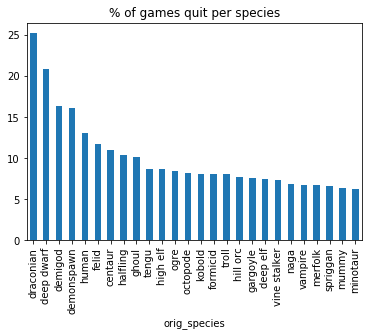

In [10]:
fr['orig_species'] = fr['species'].map(get_original_species)
quits_per_sp = fr.loc[iquit].groupby('orig_species').size()[CANON_SPECIES].dropna()
games_per_sp = fr.groupby('orig_species').size()[CANON_SPECIES].dropna()
quit_rate_per_sp = 100 * quits_per_sp / games_per_sp
quit_rate_per_sp.sort_values(ascending=0).plot.bar(title='% of games quit per species');

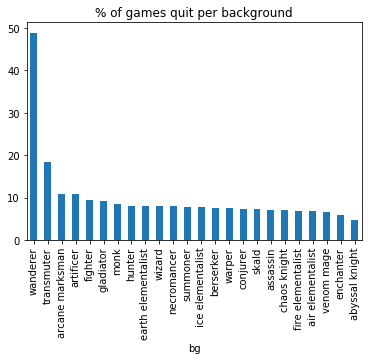

In [11]:
# What about per background?
quits_per_bg = fr.loc[iquit].groupby('bg').size()[CANON_BGS].dropna()
games_per_bg = fr.groupby('bg').size()[CANON_BGS].dropna()
quit_rate_per_bg = 100 * quits_per_bg / games_per_bg
quit_rate_per_bg.sort_values(ascending=0).plot.bar(title='% of games quit per background');
# Wanderer scumming!

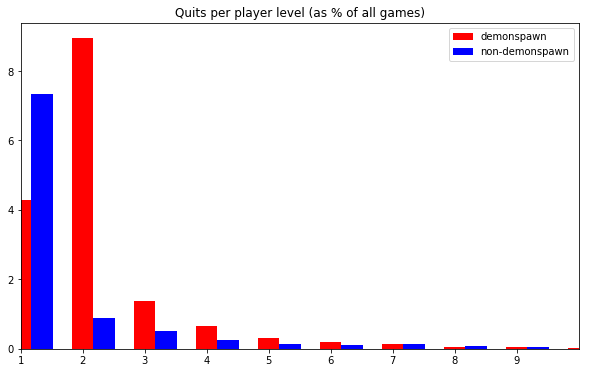

In [12]:
# What about DS scummers?
#fr.loc[iquit & (fr['species'] == 'demonspawn')].groupby('level').size().plot.bar();
# TODO: compare with all species/non-DS
# TODO: win rate of monstrous DS vs. non-monstrous

ids = fr['species'] == 'demonspawn'
ds_quits_per_lvl = (100 * fr.loc[iquit & ids].groupby('level').size() /
    ids.sum())
nonds_quits_per_lvl = (100 * fr.loc[iquit & ~ids].groupby('level').size() /
    (~ids).sum())
# TODO: write a function for this pattern
w = .35
PLVLS = np.arange(1,28)
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(ds_quits_per_lvl.index, ds_quits_per_lvl.values, w, label='demonspawn', color='r')
ax.bar(nonds_quits_per_lvl.index+w, nonds_quits_per_lvl.values, w, label='non-demonspawn', color='b')
ax.legend()
ax.set_xlim(1,10);
ax.set_xticks(range(1,10));
ax.set_title('Quits per player level (as % of all games)')
del ids

The above only includes games that ended as a result of the player quitting via ctrl+Q or taking the stairs out of the dungeon on level 1. There are probably lots of players who instead commit suicide by spamming wait until they starve or get nibbled to death by a giant newt, so these probably underestimate the number of quitters/scummers.

Could probably detect these kinds of passive suicides by looking at combat log immediately before death, and looking for stuff like "you wait"? Actually, pressing '.' doesn't echo any message to the console. Maybe grep for stuff like "The rat bites you.\nThe rat bites you."?

Okay, here's an example from morgue-WilliamCroissant-20150604-205607.txt:
```
Message History

The rat bites you but does no damage.
The rat barely misses you.
The rat bites you.
The rat bites you but does no damage.
The rat bites you.
* * * LOW HITPOINT WARNING * * *
The rat closely misses you.
The rat barely misses you.
The rat barely misses you.
The rat closely misses you.
The rat bites you but does no damage.
The rat bites you but does no damage.
The rat barely misses you.
The rat barely misses you.
The rat closely misses you.
The rat bites you.
* * * LOW HITPOINT WARNING * * *
The rat barely misses you.
The rat bites you.
You die...
```

Finding these programmatically is pretty tricky though. Just because you got smacked around by a monster 3 or 4 or 5 times in a row without taking any action yourself, doesn't necessarily imply you're giving up. It could be that you were paralyzed at the time, or you could be surrounded, so that you get hit by 3/4/5+ different monsters each turn. This query has maybe like 50% precision?
```
dweeb='(rat|hobgoblin|kobold|goblin|giant cockroach|giant newt)'
zzz="^(The $dweeb (bites|barely|closely|hits|completely)|You block the $dweeb|\* \* \* LOW HITPOINT).*\n"
find morguefiles/ -type f -exec pcregrep -H -M "${zzz}${zzz}${zzz}${zzz}${zzz}${zzz}" {} \;
```
Not sure about recall. Hard to estimate how common this is relative to ctrl+Q quitting.

1649 games out of 1295053 ended in starvation


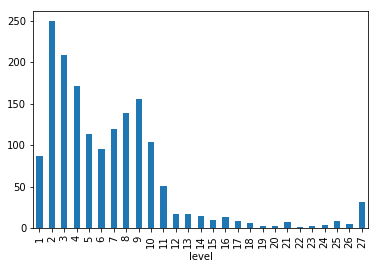

In [13]:
f[f['howdied']=='starved'].groupby('level').size().plot.bar();

print "{} games out of {} ended in starvation".format(
    (f['howdied']=='starved').sum(),
    len(f)
)

Okay well, at least hunger strikes are barely a drop in the bucket. It's pretty crazy how rare death by starvation is. Also, I'm willing to bet most of the legit starvation deaths occurred in early versions of the game. Prior to 0.12, you couldn't butcher a corpse if you were wielding a cursed blunt weapon. Ah, the good old days.

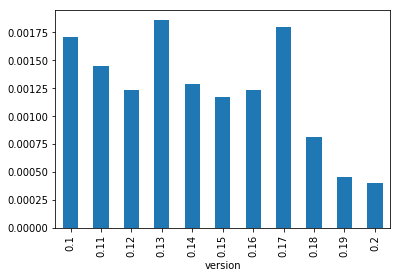

In [14]:
(f[f['howdied']=='starved'].groupby('version').size() /
 f.groupby('version').size())\
    .plot.bar();
    
# okay, .1 and .11 did have the most starvation deaths, proportionally, but not by a large margin

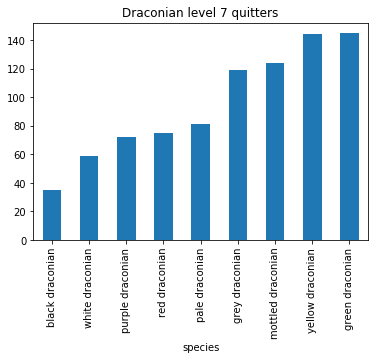

In [15]:
# Okay, which colours are people really sad to get?
f.loc[iquit & (f['level'] == 7) & idrac].groupby('species').size()\
    .where(lambda x: x > 0).dropna().sort_values().plot.bar(title='Draconian level 7 quitters');
# Not normalized, but that's fine since there's very little spread in the number of games per colour